In [1]:
import pandas as pd
import numpy as np
import sklearn as sk


from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Definition der Dataframes:

In [2]:
df_walk = pd.read_json("normal_walk.json")

df_fall = pd.read_json("fall.json")

df_testFall = pd.read_json("test_fall.json")

In [3]:
df_walk.describe()

,time,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.560600e+04,1.560600e+04,15605.000000,15605.000000,15605.000000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,1.683269e+18,-6.919721e+02,0.051799,0.440262,0.023489,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4.567039e+13,4.567039e+04,0.567014,1.009353,0.893979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.680417e+18,-2.852898e+06,-5.566208,-5.664675,-4.368199,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.683270e+18,1.962529e+01,-0.221366,-0.224200,-0.224045,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1.683270e+18,3.925919e+01,0.022858,0.793248,0.062439,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,1.683270e+18,5.889272e+01,0.314255,1.077164,0.407181,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.683270e+18,7.852227e+01,4.551981,5.324697,4.855778,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df_walk.columns

Index(['sensor', 'time', 'seconds_elapsed', 'z', 'y', 'x', 'version',
       'device name', 'recording time', 'platform', 'appVersion', 'device id',
       'sensors', 'sampleRateMs', 'yaw', 'qx', 'qz', 'roll', 'qw', 'qy',
       'pitch'],
      dtype='object')

In [5]:
#preprocessing data
df_walk['time'] = pd.to_datetime(df_walk['time'])
df_fall['time'] = pd.to_datetime(df_fall['time'])
df_testFall['time'] = pd.to_datetime(df_testFall['time'])

df_walk.head()

,sensor,time,seconds_elapsed,z,y,x,version,device name,recording time,platform,...,device id,sensors,sampleRateMs,yaw,qx,qz,roll,qw,qy,pitch
0,Accelerometer,2023-04-02 06:30:19.905724160,-2.852898e+06,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AccelerometerUncalibrated,2023-05-05 06:58:38.144353792,1.635376e-02,-0.770004,-0.392059,0.095901,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AccelerometerUncalibrated,2023-05-05 06:58:38.154418944,2.641895e-02,-0.801300,-0.401917,0.068222,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AccelerometerUncalibrated,2023-05-05 06:58:38.164484096,3.648413e-02,-0.832657,-0.412109,0.057846,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AccelerometerUncalibrated,2023-05-05 06:58:38.174548992,4.654907e-02,-0.863892,-0.420822,0.063507,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_walk = df_walk.set_index('time')
df_fall = df_fall.set_index('time')
df_testFall = df_testFall.set_index('time')

In [7]:
df_walk['sensor'].unique()

array(['Accelerometer', 'AccelerometerUncalibrated', 'Gravity',
       'Gyroscope', 'GyroscopeUncalibrated', 'Metadata', 'Orientation'],
      dtype=object)

In [8]:
df_walk_acc = df_walk[df_walk['sensor'] == 'AccelerometerUncalibrated']
df_fall_acc = df_fall[df_fall['sensor'] == 'AccelerometerUncalibrated']
df_testFall_acc = df_testFall[df_testFall['sensor'] == 'AccelerometerUncalibrated']

df_walk_gyro = df_walk[df_walk['sensor'] == 'GyroscopeUncalibrated']
df_fall_gyro = df_fall[df_fall['sensor'] == 'GyroscopeUncalibrated']
df_testFall_gyro = df_testFall[df_testFall['sensor'] == 'GyroscopeUncalibrated']

df_walk_or = df_walk[df_walk['sensor'] == 'Orientation']
df_fall_or = df_fall[df_fall['sensor'] == 'Orientation']
df_testFall_or = df_testFall[df_testFall['sensor'] == 'Orientation']


Data Preparation:

In [9]:
df_fall_or.describe()

,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.000000e+00,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,-2.852986e+06,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_walk_acc = df_walk_acc[['z','x','y']]
df_fall_acc = df_fall_acc[['z','x','y']]
df_testFall_acc = df_testFall_acc[['z','x','y']]

df_walk_gyro = df_walk_gyro[['z','x','y']]
df_fall_gyro = df_fall_gyro[['z','x','y']]
df_testFall_gyro = df_testFall_gyro[['z','x','y']]

df_walk_or = df_walk_or[['qx','qz','qw','qy']]
df_fall_or = df_fall_or[['qx','qz','qw','qy']]
df_testFall_or = df_testFall_or[['qx','qz','qw','qy']]

df_walk_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)
df_fall_gyro.rename(columns={ 'z': 'gz' , 'x': 'gx' , 'y': 'gy'}, inplace=True)


<Axes: xlabel='time'>

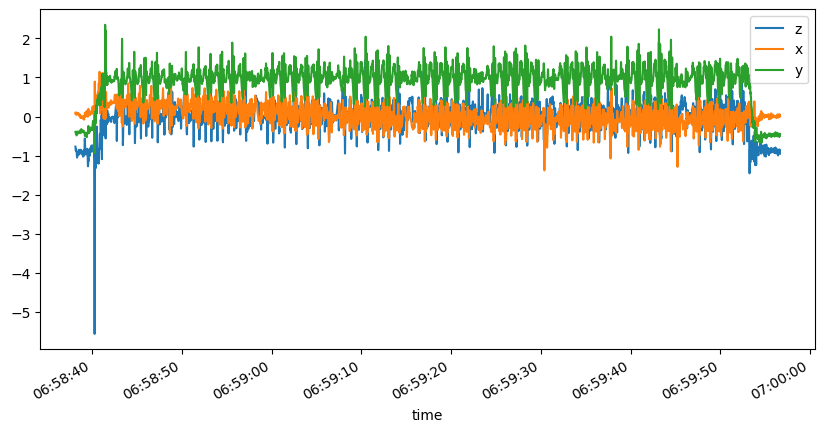

In [11]:
df_walk_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

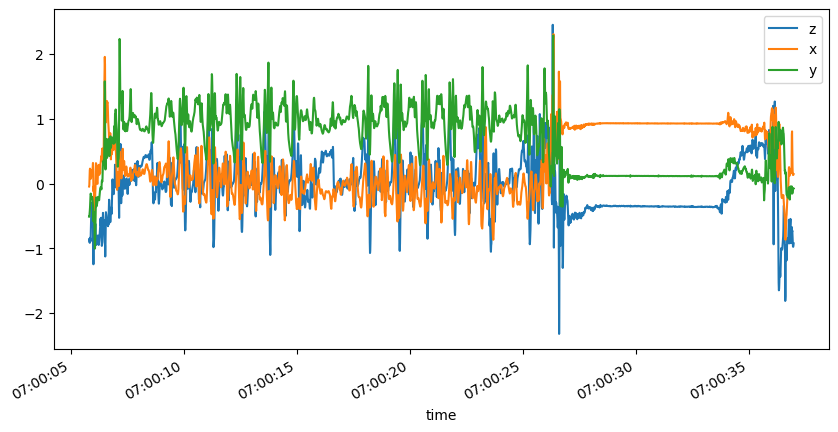

In [12]:
df_fall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

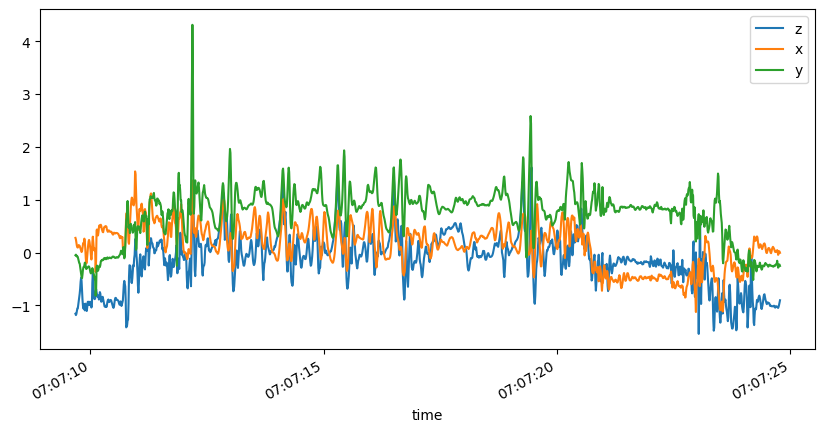

In [13]:
df_testFall_acc.plot(figsize=(10,5))

<Axes: xlabel='time'>

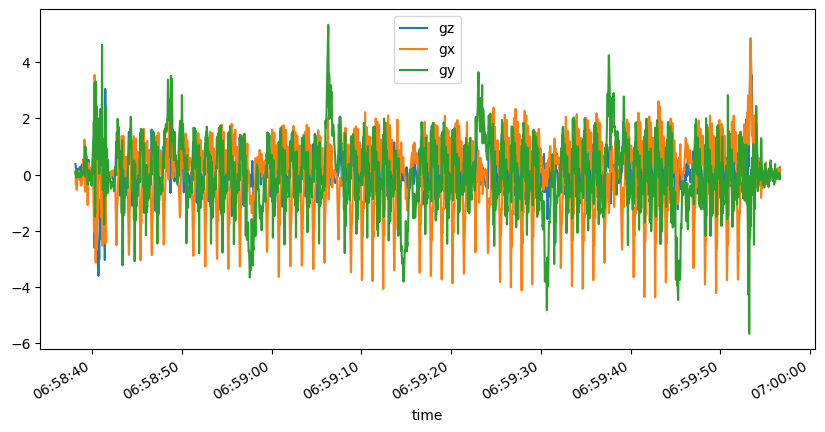

In [14]:
df_walk_gyro.plot(figsize=(10,5))

<Axes: xlabel='time'>

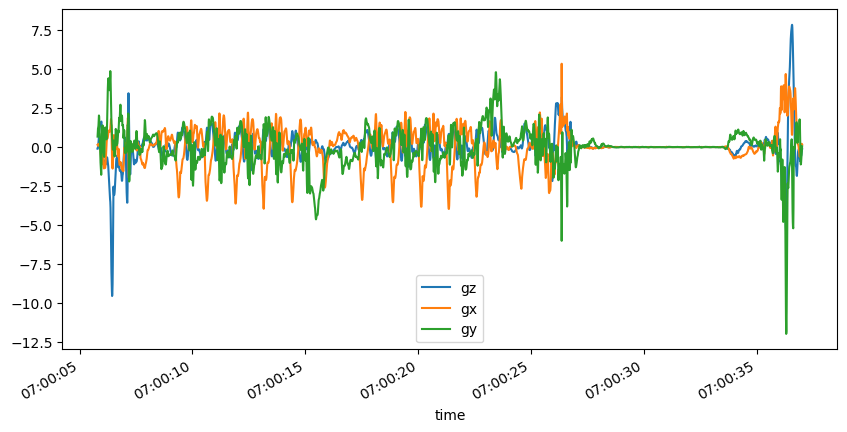

In [15]:
df_fall_gyro.plot(figsize=(10,5))

In [16]:
df_walk.describe()

,seconds_elapsed,z,y,x,version,appVersion,yaw,qx,qz,roll,qw,qy,pitch
count,1.560600e+04,15605.000000,15605.000000,15605.000000,1.0,1.00,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,-6.919721e+02,0.051799,0.440262,0.023489,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,4.567039e+04,0.567014,1.009353,0.893979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-2.852898e+06,-5.566208,-5.664675,-4.368199,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,1.962529e+01,-0.221366,-0.224200,-0.224045,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,3.925919e+01,0.022858,0.793248,0.062439,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,5.889272e+01,0.314255,1.077164,0.407181,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,7.852227e+01,4.551981,5.324697,4.855778,3.0,1.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create Training Data

In [17]:
df_walk_or

,qx,qz,qw,qy
time,,,,
2023-04-02 06:30:19.905724160,0.0,0.0,0.0,0.0


Problem bei Aufnahme der Daten, hier sollte nochmal neuer Datensatz eingepflegt werden

In [18]:
df_walk_acc['label'] = "walk"
df_fall_acc['label'] = "fall"

df_walk_gyro['label'] = "walk"
df_fall_gyro['label'] = "fall"

df_walk_or['label'] = "walk"
df_fall_or['label'] = "fall"

df_testFall_acc['label'] = "fall"
df_testFall_gyro['label'] = "fall"
df_testFall_or['label'] = "fall"

df_combined_walk = pd.merge(df_walk_acc, df_walk_gyro, on='time')
df_combined_fall = pd.merge(df_fall_acc, df_fall_gyro, on='time')

In [19]:
df_combined_walk.describe()

,z,x,y,gz,gx,gy
count,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000,7801.000000
mean,0.007949,0.011915,0.888821,0.095670,0.035072,-0.008127
std,0.414037,0.285507,0.442417,0.684032,1.231675,1.199997
min,-5.566208,-1.379913,-0.936035,-3.600134,-4.368199,-5.664675
25%,-0.146286,-0.183304,0.815964,-0.303015,-0.431574,-0.645348
50%,0.014450,0.001541,0.968018,0.042925,0.237751,-0.074779
75%,0.232178,0.202698,1.135757,0.459139,0.857483,0.722251
max,1.896194,1.145966,2.349152,4.551981,4.855778,5.324697


In [20]:
df_combined_fall.head(-5)

,z,x,y,label_x,gz,gx,gy,label_y
time,,,,,,,,
2023-05-05 07:00:05.796345344,-0.858704,-0.043808,-0.510193,fall,-0.107170,0.143945,0.668648,fall
2023-05-05 07:00:05.806409472,-0.895935,-0.021576,-0.511230,fall,-0.108921,0.115393,0.904805,fall
2023-05-05 07:00:05.816474368,-0.902679,0.091705,-0.473236,fall,0.010160,0.078004,1.210142,fall
2023-05-05 07:00:05.826539264,-0.914108,0.206802,-0.422516,fall,0.160927,0.132769,1.255230,fall
2023-05-05 07:00:05.836603392,-0.835724,0.232285,-0.367661,fall,0.297366,0.192376,1.384964,fall
...,...,...,...,...,...,...,...,...
2023-05-05 07:00:36.906024448,-0.727997,0.249161,-0.148407,fall,-0.912278,-0.531905,0.746090,fall
2023-05-05 07:00:36.916088320,-0.670898,0.756439,-0.043152,fall,-0.565928,-0.367368,-0.153228,fall
2023-05-05 07:00:36.926153472,-0.746384,0.807922,-0.078064,fall,-0.435041,-0.237608,-0.687723,fall


In [21]:
df_combined_walk.drop('label_x',axis=1, inplace=True)
df_combined_fall.drop('label_x',axis=1, inplace=True)

In [22]:
#Anzahl der Reihen RowCount Check auf Vollständigkeit
laenge = len(df_walk_acc) + len(df_walk_gyro)
print(laenge)
print(len(df_walk_acc))

15602
7801


Aufteilen der DF's in einzelne Abschnitte mit den Abständen XX:

In [23]:
df_combined_walk['id'] = 0
df_combined_fall['id'] = 0

id = 1

var1 = 100
var2 = 100

for i in range(0, len(df_combined_walk)):
    df_combined_walk.iloc[i,7] = id
    

    if i >= var1: 
        var1 = var1 + 100
        id+=1
    
for i in range(0, len(df_combined_fall)):
    
    df_combined_fall.iloc[i,7] = id

    if i >= var2: 
        var2 = var2 + 100
        id+=1  

In [24]:
df_combined_walk

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,walk,1
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,walk,1
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,walk,1
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,walk,1
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,walk,1
...,...,...,...,...,...,...,...,...
2023-05-05 06:59:56.610012928,-0.848389,0.046661,-0.506805,0.156614,-0.159282,0.041310,walk,78
2023-05-05 06:59:56.620076800,-0.861221,0.055542,-0.488983,0.198738,-0.107488,-0.042373,walk,78
2023-05-05 06:59:56.630141952,-0.900436,0.041672,-0.465683,0.213338,0.035620,-0.167855,walk,78


In [25]:
df_combined_fall

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-05 07:00:05.796345344,-0.858704,-0.043808,-0.510193,-0.107170,0.143945,0.668648,fall,79
2023-05-05 07:00:05.806409472,-0.895935,-0.021576,-0.511230,-0.108921,0.115393,0.904805,fall,79
2023-05-05 07:00:05.816474368,-0.902679,0.091705,-0.473236,0.010160,0.078004,1.210142,fall,79
2023-05-05 07:00:05.826539264,-0.914108,0.206802,-0.422516,0.160927,0.132769,1.255230,fall,79
2023-05-05 07:00:05.836603392,-0.835724,0.232285,-0.367661,0.297366,0.192376,1.384964,fall,79
...,...,...,...,...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,-0.561477,0.103614,-0.864238,fall,109
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,-0.470264,0.181803,-0.671422,fall,109
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,-0.320177,0.209357,-0.403196,fall,109


In [26]:
df_combined = pd.concat([df_combined_walk, df_combined_fall])

In [27]:
df_combined

,z,x,y,gz,gx,gy,label_y,id
time,,,,,,,,
2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,walk,1
2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,walk,1
2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,walk,1
2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,walk,1
2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,walk,1
...,...,...,...,...,...,...,...,...
2023-05-05 07:00:36.956347136,-0.940689,0.155502,-0.105499,-0.561477,0.103614,-0.864238,fall,109
2023-05-05 07:00:36.966411264,-0.969910,0.134750,-0.089905,-0.470264,0.181803,-0.671422,fall,109
2023-05-05 07:00:36.976476416,-0.975662,0.134018,-0.077606,-0.320177,0.209357,-0.403196,fall,109


Check auf Nullwerte:

In [28]:
df_combined.isnull().sum()

z          0
x          0
y          0
gz         0
gx         0
gy         0
label_y    0
id         0
dtype: int64

In [29]:
df_combined.reset_index(inplace=True)
df_combined.head()

,time,z,x,y,gz,gx,gy,label_y,id
0,2023-05-05 06:58:38.144353792,-0.770004,0.095901,-0.392059,0.372627,-0.326558,0.034030,walk,1
1,2023-05-05 06:58:38.154418944,-0.801300,0.068222,-0.401917,0.323937,-0.311438,0.098708,walk,1
2,2023-05-05 06:58:38.164484096,-0.832657,0.057846,-0.412109,0.290018,-0.266175,0.137501,walk,1
3,2023-05-05 06:58:38.174548992,-0.863892,0.063507,-0.420822,0.261301,-0.182474,0.126971,walk,1
4,2023-05-05 06:58:38.184613888,-0.873398,0.073227,-0.429611,0.247048,-0.094612,0.046177,walk,1


In [30]:
from tsfresh import extract_features
extracted_features = extract_features(df_combined, column_id="id",column_sort='time')

Feature Extraction:   0%|          | 0/25 [00:02<?, ?it/s]


TypeError: acf() got an unexpected keyword argument 'unbiased'

In [ ]:
#Split Data 
X_train, X_test, y_train, y_test = train_test_split(df_combined.drop('label_y',axis=1), df_combined['label_y'], test_size=0.30, random_state=101)

In [ ]:
X_test

,z,x,y,gz,gx,gy,id
time,,,,,,,
2023-05-05 06:58:57.026100736,0.149124,-0.090210,1.279327,-0.407610,1.165038,0.060769,19
2023-05-05 06:59:25.247685120,0.292587,0.159637,1.082748,-0.438289,0.240834,-0.519146,47
2023-05-05 06:59:53.639731456,-0.786591,-0.057083,-0.130875,1.091541,1.201911,0.480524,76
2023-05-05 06:59:31.839993088,-0.023117,-0.057129,0.933792,0.012574,0.695619,-0.743843,54
2023-05-05 07:00:10.526701056,0.113434,0.243790,1.279816,0.329290,0.117740,-0.292410,83
...,...,...,...,...,...,...,...
2023-05-05 06:59:30.088757504,-0.065414,-0.008347,1.024826,-0.402615,0.535307,-0.718141,52
2023-05-05 06:59:46.705300224,-0.000412,-0.031754,1.033798,-0.253334,0.418694,-0.430545,69
2023-05-05 07:00:11.684130304,0.011993,0.177902,1.036865,-0.600731,0.317354,-0.509279,84


In [ ]:
y_test

time
2023-05-05 06:58:57.026100736    walk
2023-05-05 06:59:25.247685120    walk
2023-05-05 06:59:53.639731456    walk
2023-05-05 06:59:31.839993088    walk
2023-05-05 07:00:10.526701056    fall
                                 ... 
2023-05-05 06:59:30.088757504    walk
2023-05-05 06:59:46.705300224    walk
2023-05-05 07:00:11.684130304    fall
2023-05-05 07:00:16.565462784    fall
2023-05-05 06:59:33.571098112    walk
Name: label_y, Length: 3271, dtype: object

In [ ]:
#KNN
knn = KNeighborsClassifier(n_neighbors=3,weights='distance')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)

In [ ]:
#Test via Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 920    0]
 [   0 2351]]


Mittels TSFresh Features extrahieren um damit bessere Auswertung zu ermöglichen